<a href="https://colab.research.google.com/github/JenBanks8585/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Jen_Banks_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [71]:
df.head(1)

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.8,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
# Drop columns 'Queso", no single entry

df = df.drop(columns=['Queso'])

In [77]:
print(df.shape)
df.head(3)

(421, 58)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


###Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [81]:
df.dtypes.head(2)

Burrito    object
Date       object
dtype: object

In [95]:
df.isnull().sum().head(3)

Burrito      0
Date         0
Yelp       334
dtype: int64

In [0]:
import datetime as dt

# convert the 'Date' column to datetime format 

df['Date']= pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce') 
#df.sort_values(by=['Date'], ascending=True, inplace= True)

In [84]:
df['Date']

0     2016-01-18
1     2016-01-24
2     2016-01-24
3     2016-01-24
4     2016-01-27
         ...    
418   2019-08-27
419   2019-08-27
420   2019-08-27
421   2019-08-27
422   2019-08-27
Name: Date, Length: 421, dtype: datetime64[ns]

In [85]:
#Grabbing validation set

train= df[(df['Date']<='2016-12-31')]
print(train.shape)
train.head(2)

(298, 58)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [86]:
#Grabbing train set

val= df[(df['Date']>'2016-12-31') & (df['Date']<='2017-12-31')]
print(val.shape)
val.head(2)

(85, 58)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,2017-01-04,NaN,NaN,NaN,6.6,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
302,Other,2017-01-04,NaN,NaN,NaN,6.6,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [87]:
#Grabbing test set

test= df[(df['Date']>'2017-12-31')]
print(test.shape)
test.head(2)

(38, 58)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [88]:
# Inspecting 'SALE_DATE'
train['Great'].value_counts()

False    176
True     122
Name: Great, dtype: int64

### Begin with baselines for classification.

In [89]:
#Determining the majority class

target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred_train = [majority_class]*len(y_train)

In [91]:
#baseline accuracy rate of training set

from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred_train)

0.5906040268456376

In [92]:
#Computing for accuracy score of validation set

y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [93]:
# Training set description
 
 train.describe().T

,count,mean,std,min,25%,50%,75%,max
Yelp,71.0,3.897183,0.478680,2.50,3.5000,4.00,4.00,4.50
Google,71.0,4.142254,0.371738,2.90,4.0000,4.20,4.40,4.90
Cost,292.0,6.896781,1.211412,2.99,6.2500,6.85,7.50,11.95
Hunger,297.0,3.445286,0.852150,0.50,3.0000,3.50,4.00,5.00
Mass (g),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,175.0,19.829886,2.081275,15.00,18.5000,19.50,21.00,26.00
Circum,174.0,22.042241,1.685043,17.00,21.0000,22.00,23.00,27.00
Volume,174.0,0.770920,0.137833,0.40,0.6625,0.75,0.87,1.24
Tortilla,298.0,3.472315,0.797606,1.40,3.0000,3.50,4.00,5.00


In [96]:
train.isnull().sum()

Burrito             0
Date                0
Yelp              227
Google            227
Chips             276
Cost                6
Hunger              1
Mass (g)          298
Density (g/mL)    298
Length            123
Circum            124
Volume            124
Tortilla            0
Temp               15
Meat               10
Fillings            1
Meat:filling        6
Uniformity          2
Salsa              20
Synergy             2
Wrap                2
Unreliable        271
NonSD             293
Beef              130
Pico              155
Guac              159
Cheese            149
Fries             179
Sour cream        213
Pork              255
Chicken           278
Shrimp            278
Fish              293
Rice              265
Beans             266
Lettuce           287
Tomato            291
Bell peper        291
Carrots           297
Cabbage           291
Sauce             261
Salsa.1           292
Cilantro          283
Onion             281
Taquito           294
Pineapple 

#### Running a Linear Regression

In [97]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Cost', 'Fillings', 'Hunger']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

array([ 0.39874684,  0.56528984,  0.27382803,  0.26819121,  0.04395152,
        0.41045983,  0.57031149,  0.5860732 , -0.04003229,  0.41932401,
        0.47301921,  0.42238936,  0.5726434 ,  0.404066  ,  0.5860192 ,
        0.59594511,  0.53975289,  0.55504661,  0.57045681,  0.57045681,
        0.57045681,  0.24478872,  0.23025728,  0.59546463,  0.76288639,
        0.58093319,  0.65542898,  0.41802305,  0.58093319,  0.42435954,
        0.52303486,  0.25786701,  0.24043616,  0.24043616,  0.43442983,
        0.47141431,  0.25654249,  0.37993694,  0.52999209,  0.41963249,
        0.26711313,  0.45057347,  0.2529332 ,  0.5860192 ,  0.40589421,
        0.41205829, -0.19548427,  0.07315971,  0.58644139, -0.09338329,
        0.0884246 ,  0.40900669,  0.60113189,  0.60113189,  0.42944889,
        0.24681624,  0.22050746,  0.35450004,  0.23418764,  0.38532044,
       -0.08567475,  0.41133172,  0.2241472 ,  0.4215106 ,  0.60383199,
        0.60999607,  0.41802305,  0.93436321,  0.29014055,  0.40

In [98]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

Cost        0.014531
Fillings    0.333086
Hunger      0.030820
dtype: float64

In [99]:
#Predicting whether 'Cost'=5, 'Fillings'=3, 'Hunger'=2 is great or otherwise

#Results suggest, most likely not great

test_case = [[5, 3, 2]]  
linear_reg.predict(test_case)

array([0.16440924])

###Use scikit-learn for logistic regression.
#### Running a Logistic Regression
 

In [104]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

# same thing
y_pred = log_reg.predict(X_val_imputed)
print('Validation Accuracy', accuracy_score(y_pred, y_val))

Validation Accuracy 0.8235294117647058
Validation Accuracy 0.8235294117647058


In [105]:
# The predictions look like this
log_reg.predict(X_val_imputed)

array([False,  True, False, False, False, False,  True,  True, False,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True, False,
        True, False,  True,  True])

In [106]:
log_reg.predict(test_case)

#Results support that of Linear Regression 

array([False])

In [107]:
log_reg.predict_proba(test_case)[0]

array([0.90499816, 0.09500184])

In [108]:
# Determining coefficients
log_reg.coef_

array([[0.12635681, 2.10588278, 0.20305045]])

In [109]:
log_reg.intercept_

array([-9.60957])

In [0]:
# The logistic sigmoid "squishing" function, implemented to accept numpy arrays
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

In [111]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.09500184]])

In [112]:
1 - sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.90499816]])

###Get your model's validation accuracy. (Multiple times if you try multiple iterations.)


####Fit this sequence of transformers & estimator:

#####-category_encoders.one_hot.OneHotEncoder
#####-sklearn.impute.SimpleImputer
#####-sklearn.preprocessing.StandardScaler
#####-sklearn.linear_model.LogisticRegressionCV

Get validation accuracy.

In [120]:
train.isnull().sum()

Burrito             0
Date                0
Yelp              227
Google            227
Chips             276
Cost                6
Hunger              1
Mass (g)          298
Density (g/mL)    298
Length            123
Circum            124
Volume            124
Tortilla            0
Temp               15
Meat               10
Fillings            1
Meat:filling        6
Uniformity          2
Salsa              20
Synergy             2
Wrap                2
Unreliable        271
NonSD             293
Beef              130
Pico              155
Guac              159
Cheese            149
Fries             179
Sour cream        213
Pork              255
Chicken           278
Shrimp            278
Fish              293
Rice              265
Beans             266
Lettuce           287
Tomato            291
Bell peper        291
Carrots           297
Cabbage           291
Sauce             261
Salsa.1           292
Cilantro          283
Onion             281
Taquito           294
Pineapple 

In [122]:
features = ['Cost', 'Fillings', 'Hunger','Tortilla','Meat:filling','Tortilla','Salsa', 'Temp' ]
target = "Great"

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, X_val.shape

((298, 8), (85, 8))

In [0]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [124]:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_train_enc.shape, X_val_enc.shape

((298, 8), (85, 8))

In [125]:
X_val_enc.head()

,Cost,Fillings,Hunger,Tortilla,Meat:filling,Tortilla,Salsa,Temp
301,6.60,3.5,NaN,4.0,3.5,4.0,1.5,4.5
302,6.60,4.0,NaN,4.0,NaN,4.0,4.2,2.0
303,8.50,3.0,3.9,3.0,3.7,3.0,4.3,4.5
304,7.90,3.0,4.0,3.5,4.0,3.5,4.0,4.0
305,4.99,2.5,3.5,2.5,3.0,2.5,2.0,4.5


In [130]:
imputer = SimpleImputer(strategy='most_frequent')
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)
X_train_imp.shape, X_val_imp.shape

((298, 8), (85, 8))

In [0]:
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns = X_val_enc.columns)

In [132]:
X_val_imp

,Cost,Fillings,Hunger,Tortilla,Meat:filling,Tortilla,Salsa,Temp
0,6.60,3.5,4.0,4.0,3.5,4.0,1.5,4.5
1,6.60,4.0,4.0,4.0,4.0,4.0,4.2,2.0
2,8.50,3.0,3.9,3.0,3.7,3.0,4.3,4.5
3,7.90,3.0,4.0,3.5,4.0,3.5,4.0,4.0
4,4.99,2.5,3.5,2.5,3.0,2.5,2.0,4.5
...,...,...,...,...,...,...,...,...
80,6.85,3.8,3.5,3.0,4.0,3.0,3.5,4.5
81,6.85,4.0,3.5,3.0,4.5,3.0,4.0,4.5
82,11.50,3.5,3.5,2.0,3.0,2.0,3.5,2.0
83,7.89,4.0,4.0,4.0,3.0,4.0,3.5,3.0


In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

In [0]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns = X_val_enc.columns)

In [135]:

X_train_sc.head()

,Cost,Fillings,Hunger,Tortilla,Meat:filling,Tortilla,Salsa,Temp
0,-0.327984,-0.024338,-0.526123,-0.593162,0.448071,-0.593162,0.741728,1.322453
1,-1.194259,-1.203659,0.062187,-1.849023,-1.493126,-1.849023,0.209755,-0.228679
2,-1.694033,-0.613999,-2.291054,-0.593162,0.933371,-0.593162,-0.322219,-1.779812
3,-1.360851,-0.613999,-1.702744,-0.593162,0.448071,-0.593162,0.741728,-1.779812
4,-0.244688,-0.024338,0.650498,0.662698,0.933371,0.662698,-0.854192,1.322453


In [136]:
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [137]:
print(f'Validation score: {model.score(X_val_sc, y_val)}')

Validation score: 0.788235294117647


In [138]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Cost            0.215309
Fillings        0.857915
Hunger          0.127956
Tortilla        0.227657
Meat:filling    0.674753
Tortilla        0.227657
Salsa           0.395384
Temp            0.321827
dtype: float64

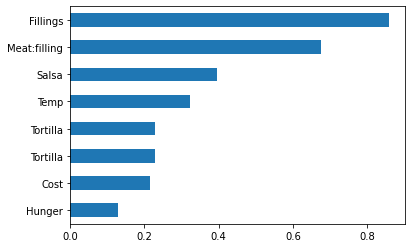

In [143]:
coefs.sort_values().plot.barh();

### Get your model's test accuracy. (One time, at the end.)

In [0]:
X_test = test[features]
X_test_enc = encoder.transform(X_test)
X_test_imp = imputer.transform(X_test_enc)
X_test_scaled = scaler.transform(X_test_imp)


In [0]:
y_pred = model.predict(X_test_scaled)